<h1><center>Сегментация клиентов немецкого банка при помощи методов кластеризации и методов уменьшения размерности</center></h1>

**Подключение необходимых библиотек и загрузка данных**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import CountEncoder
import umap
from itertools import combinations
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

plt.style.use('seaborn-whitegrid')
pd.set_option("display.max_columns", None)

In [2]:
data = pd.read_csv('data/german_credit_data.csv')
data

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
...,...,...,...,...,...,...,...,...,...,...
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,996,40,male,3,own,little,little,3857,30,car
997,997,38,male,2,own,little,NaN,804,12,radio/TV
998,998,23,male,2,free,little,little,1845,45,radio/TV


In [3]:
data.drop(columns=["Unnamed: 0"], inplace=True)
data.shape

(1000, 9)

<h2>EDA</h2>

<h3>Знакомство с данными</h3>

В загруженном наборе данных присутствуют следующие атрибуты:
<ol>
    <li>Возраст (числовой)</li>
    <li>Пол (категории: мужской, женский)</li>
    <li>Работа (ранги: 0 — неквалифицированный и нерезидент, 1 — неквалифицированный и резидент, 2 — квалифицированный, 3 — высококвалифицированный)</li>
    <li>Жилье (категории: собственное, арендованное или бесплатное)</li>
    <li>Сберегательные счета (категории: мало, среднее, довольно богатый, богатый)</li>
    <li>Текущий счет (категории: мало, среднее, богатый)</li>
    <li>Сумма кредита (числовой, в немецких марках)</li>
    <li>Продолжительность (числовой, в месяцах)</li>
    <li>Цель (категории: автомобиль, мебель/оборудование, радио/телевизор, бытовая техника, ремонт, образование, бизнес, отпуск/другое)</li>
</ol>

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


Пропуски есть в 2 переменных, вычислим их долю. Также посмотрим есть ли дубли.

In [5]:
print(f"Число дублей {data.duplicated().sum()}")

print(f"Для признака Saving accounts: {100 * data['Saving accounts'].isna().sum() / data.shape[0]:.0f}%", 
      f"Для признака Checking account: {100 * data['Checking account'].isna().sum() / data.shape[0]:.0f}%", 
      sep="\n")

Число дублей 0
Для признака Saving accounts: 18%
Для признака Checking account: 39%


**Для дальнейшего анализа выделим количественные и качественные признаки.<br/>Используем для этого типы данных и знания о наборе данных.**

In [6]:
data["Job"] = data["Job"].astype("object") # Так как значения Job представлены в ранговой шкале

quantitative = data.select_dtypes(include="number").columns.tolist()
qualitative = data.select_dtypes(include="object").columns.tolist()

print("Количественные признаки:", quantitative)
print("Качественные признаки:", qualitative)

Количественные признаки: ['Age', 'Credit amount', 'Duration']
Качественные признаки: ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']


*Посмотрим на основные характеристики переменных*

In [7]:
data[quantitative].describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [8]:
data[qualitative].describe()

,Sex,Job,Housing,Saving accounts,Checking account,Purpose
count,1000,1000,1000,817,606,1000
unique,2,4,3,4,3,8
top,male,2,own,little,little,car
freq,690,630,713,603,274,337


<h3>Анализ количественных признаков</h3>

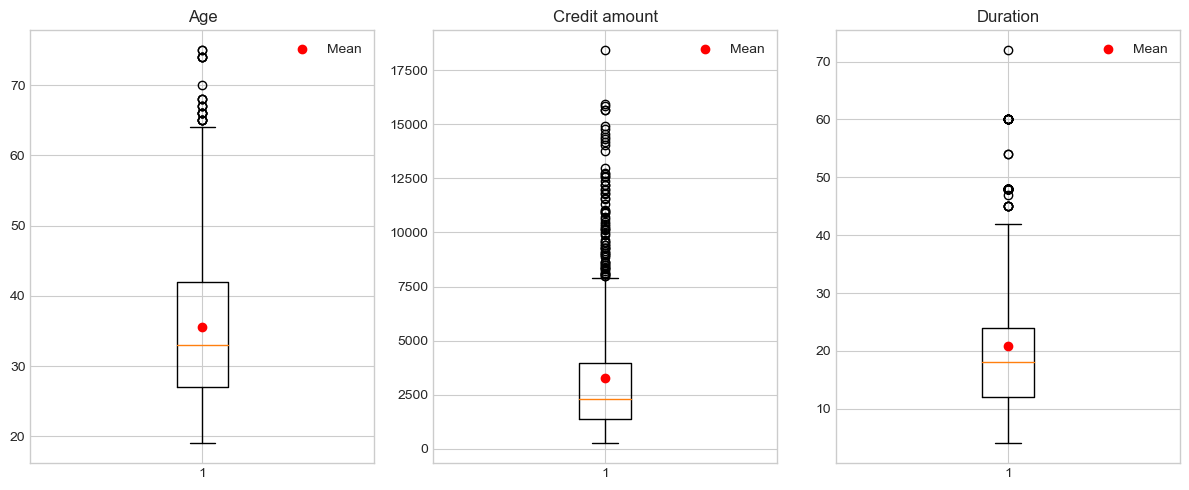

In [9]:
num_columns = len(quantitative)

ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
axes = axes.flatten()

for i, column in enumerate(quantitative):
    axes[i].boxplot(data[column])
    axes[i].set_title(f"{column}")
    
    mean = data[column].mean()
    
    axes[i].scatter(1, mean, color='red', label='Mean', zorder=3)
    
    
    axes[i].legend(loc='upper right')


plt.tight_layout()
plt.show()

Больше всего выбросов у непрерывной величины **Credit amount**

In [10]:
data[quantitative].corr()

,Age,Credit amount,Duration
Age,1.000000,0.032716,-0.036136
Credit amount,0.032716,1.000000,0.624984
Duration,-0.036136,0.624984,1.000000


Cильно коррелированных между собой признаков нет

Проверим подчиняются ли количественные переменные нормальному распределению (это необходимо для выбора способа обработки аномалий). Применим тест Шапиро-Уилка

In [11]:
alpha = 0.05 # выбранный уровень значимости
passed_test = []
for column in quantitative:
    statistics, pvalue = stats.shapiro(data[column])
    passed_test.append(pvalue >= alpha)
    
print(f"Количество признаков, прошедших тест на нормальность: {sum(passed_test)} из {len(quantitative)}")

Количество признаков, прошедших тест на нормальность: 0 из 3


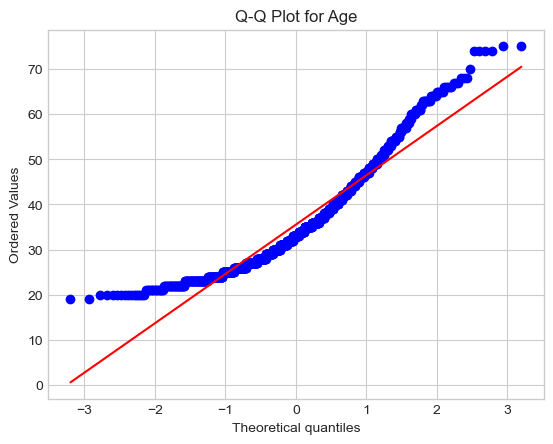

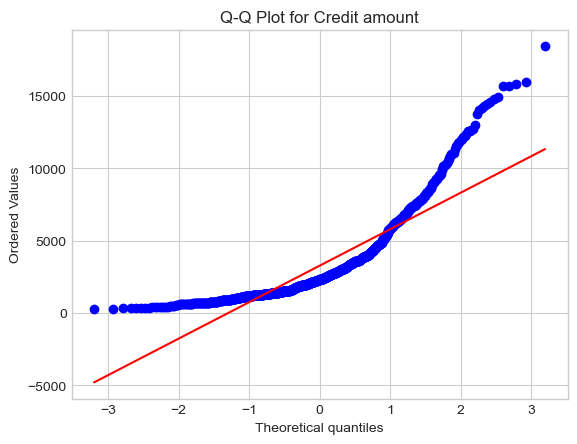

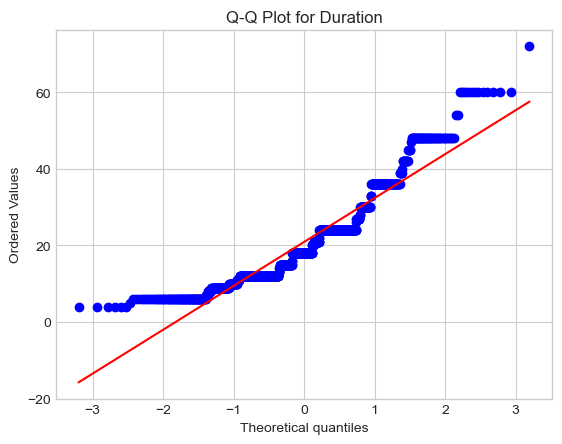

In [12]:
for column in quantitative:
    stats.probplot(data[column], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {column}")
    plt.show()

На основании **результатов теста и QQplot** мы **не можем считать** что 1 из 3 количественных переменных порождена случайной величиной с нормальным распределением

<h3>Анализ качественных признаков</h3>

In [13]:
for column in qualitative:
    print(F"Количество объектов в разрезе классов для", column)
    print(data[column].value_counts())
    print("-"*50, end="\n\n")

Количество объектов в разрезе классов для Sex
male      690
female    310
Name: Sex, dtype: int64
--------------------------------------------------

Количество объектов в разрезе классов для Job
2    630
1    200
3    148
0     22
Name: Job, dtype: int64
--------------------------------------------------

Количество объектов в разрезе классов для Housing
own     713
rent    179
free    108
Name: Housing, dtype: int64
--------------------------------------------------

Количество объектов в разрезе классов для Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
--------------------------------------------------

Количество объектов в разрезе классов для Checking account
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
--------------------------------------------------

Количество объектов в разрезе классов для Purpose
car                    337
radio/TV               280
furnitur

! Подробнее анализ качественных признаков проведем после обработки пропусков

<h2>Preprocessing</h2>

<h3>Пропуски</h3>

Доля пропусков, обнаруженных в обоих признаках, составляет более 5% и меньше 50%, поэтому не будем удалять строки и/или столбцы.<br>Стоит отметить, что информация о сберегательном и текущем счетах может быть очень важна и неизвестна причина отсутствия данных (так как неизвестны методы сбора данных). ***Поэтому для обоих признаков заменим пропуски наиболее встречаемым значением.***

In [14]:
data.loc[data["Saving accounts"].isna(), "Saving accounts"] = data["Saving accounts"].mode()[0]
data.loc[data["Checking account"].isna(), "Checking account"] = data["Checking account"].mode()[0]

<h3><i>Возвращаемся к анализу</i></h3>

Применим тест χ² для выявления зависимостей между всевозможными парами категориальных переменных

In [15]:
qualitative_combinations = combinations(qualitative, 2)
dependent_pairs = []
i = 0

for feature_1, feature_2 in qualitative_combinations:
    contingency_table = pd.crosstab(data[feature_1], data[feature_2])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    alpha = 0.01
    if p < alpha:
        dependent_pairs.append((feature_1, feature_2))
        
    i += 1
    
print(f"Всего рассмотренных комбинаций переменных для выявления завизимостей - {i}")
print(f"Из ниж для {len(dependent_pairs)} пар признаков отвергнута нулевая гиротеза о независимости переменных:")
print("\n".join(map(lambda x: f"{x[0]} ~ {x[1]}", dependent_pairs)))

Всего рассмотренных комбинаций переменных для выявления завизимостей - 15
Из ниж для 6 пар признаков отвергнута нулевая гиротеза о независимости переменных:
Sex ~ Housing
Sex ~ Purpose
Job ~ Housing
Job ~ Purpose
Housing ~ Purpose
Saving accounts ~ Checking account


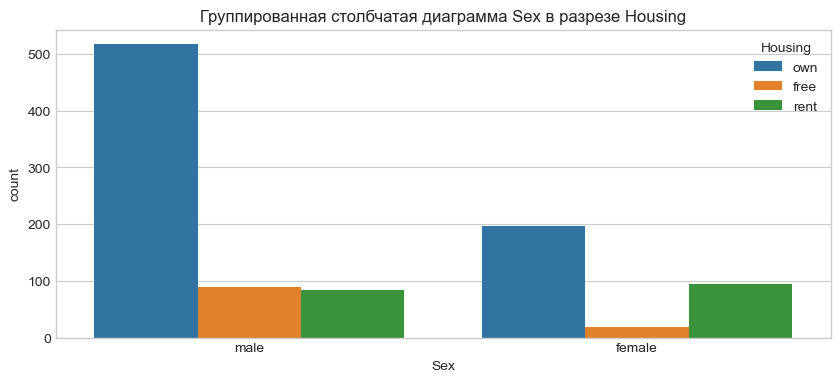

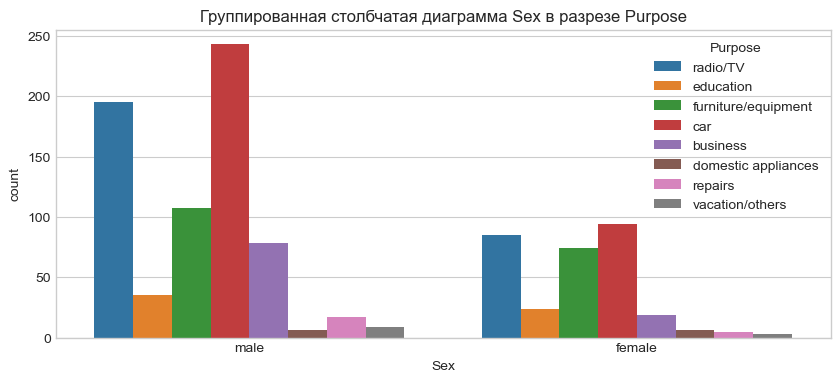

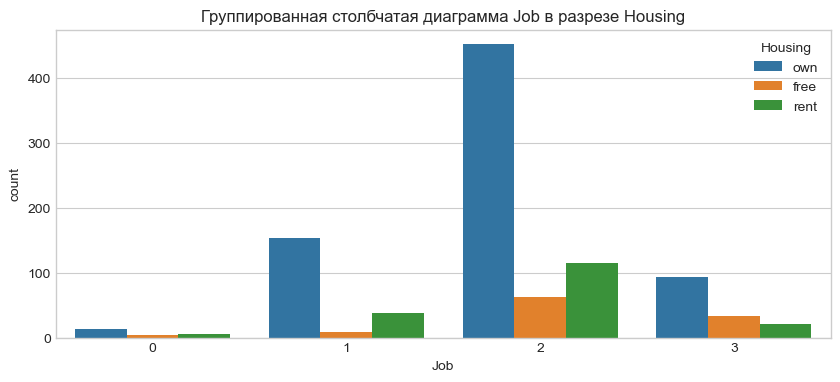

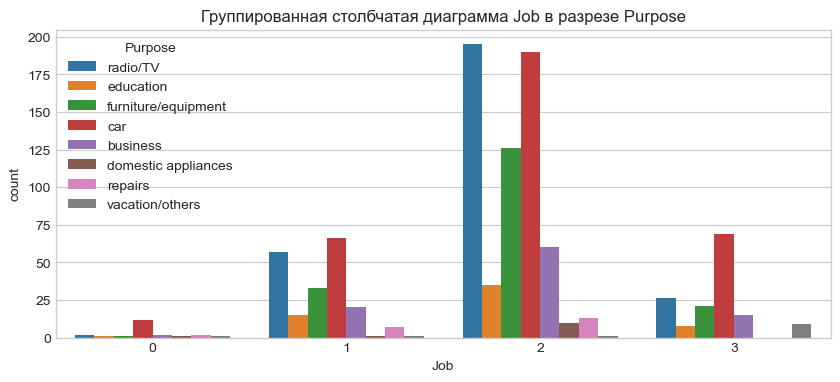

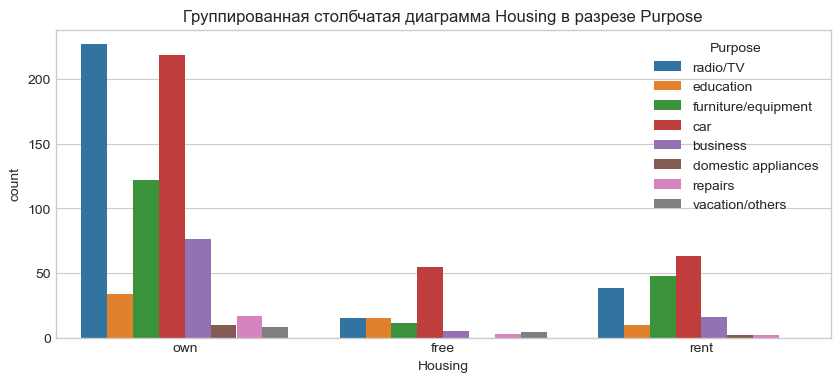

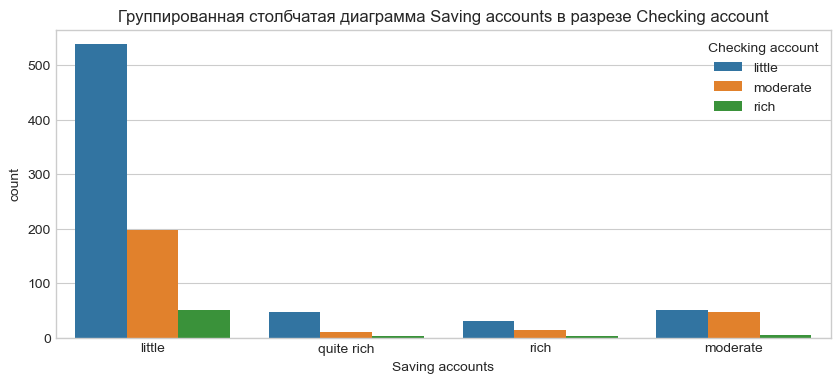

In [16]:
for feature_1, feature_2 in dependent_pairs:
    plt.figure(figsize=(10, 4))
    sns.countplot(data=data, x=feature_1, hue=feature_2)
    plt.title(f"Группированная столбчатая диаграмма {feature_1} в разрезе {feature_2}")
    plt.show()

<h3>Аномалии</h3>

Так как распределения величин не прошли проверку на нормальность,<br>**будем считать выбросами** те значения, которые лежат за пределами: <center>$[Q1 - 1.5*IQR, Q3 + 1.5*IQR]$</center>
Заменим их на медиану

In [17]:
for column in quantitative:
    q1 = np.percentile(data[column], 25)
    q3 = np.percentile(data[column], 75)
    iqr = q3 - q1

    lower_bound_mpa = q1 - 1.5 * iqr
    upper_bound_mpa = q3 + 1.5 * iqr
    
    data.loc[(data[column] < lower_bound_mpa) | (data[column] > upper_bound_mpa), column] = data[column].median()

<h2>Data Transformation</h2>

<h3>Кодирование признаков</h3>

Используем **CountEncoder** - кодирование категорий на основании **абсолютного количества их появлений** в выборке

In [18]:
for_encoding = qualitative.copy()
for_encoding.remove("Job")

encoder = CountEncoder()
encoded = encoder.fit_transform(data[for_encoding])

data_encoded = data.copy()
data_encoded.loc[:, for_encoding] = encoded
data_encoded

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,33,690,2,713,786,668,1169.0,6,280
1,22,310,2,713,786,269,5951.0,18,280
2,49,690,1,713,786,668,2096.0,12,59
3,45,690,2,108,786,668,7882.0,42,181
4,53,690,2,108,786,668,4870.0,24,337
...,...,...,...,...,...,...,...,...,...
995,31,310,1,713,786,668,1736.0,12,181
996,40,690,3,713,786,668,3857.0,30,337
997,38,690,2,713,786,668,804.0,12,280
998,23,690,2,108,786,668,1845.0,18,280


<h3>Масштабирование признаков</h3>

**Алгоритмы кластеризации чувствительны к масштабам признаков ввиду того, что  в процессе обучения моделей (основанных на таких алгоритмах) учитываются расстояния между объектами и кластерами (как правило, евклидово). Без применения масштабирования признаки с большими диапазонами значений несут доминирующий вклад в определение расстояния, что негативно отражается на выявлении кластеров.**

In [19]:
scaler = MinMaxScaler()

columns = data_encoded.columns
data_encoded = scaler.fit_transform(data_encoded)
data_encoded = pd.DataFrame(data_encoded, columns=columns)

# Проверка того что все переменные прошли через маштабирование
pd.DataFrame({"min": data_encoded.min(), "max": data_encoded.max()}).T

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<h2>Выявление кластеров с помощью методов кластеризации</h2>

In [20]:
# Методы кластеризации и их метки
cluster_methods = {
    "KMeans": None,
    "Hierarchical": None,
    "DBSCAN": None,
}

max_clusters = 12 # Максимальное количество искомых кластеров (для KMeans и иерархической кластеризации)

<h3>KMeans</h3>

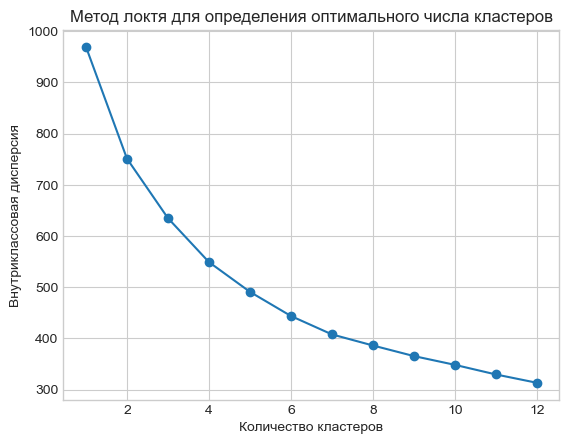

In [21]:
sse, siluette_scores = [], []
kmeans_labels_variants = []

for i in range(1, max_clusters+1):
    kmeans_model = KMeans(i, random_state=42)
    kmeans_model.fit(data_encoded)
    sse.append(kmeans_model.inertia_)
    
    # Силуэт не рассчитывается для одного кластера
    if i > 1:
        # +1 к меткам для удобной работы, визуализации и интерпретации
        siluette_scores.append(silhouette_score(data_encoded, kmeans_model.labels_ + 1))
        kmeans_labels_variants.append(kmeans_model.labels_ + 1) 
    
plt.scatter(range(1, max_clusters+1), sse)
plt.plot(range(1, max_clusters+1), sse)
plt.title("Метод локтя для определения оптимального числа кластеров")
plt.xlabel('Количество кластеров')
plt.ylabel('Внутриклассовая дисперсия')
plt.show()

*Вычислим переломные моменты:*
$D_k = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}$

In [22]:
d_values = []  # Список для хранения значений D(k)
for k in range(1, len(sse) - 1):  # Проходим от второго до предпоследнего кластера
    d_k = abs(sse[k] - sse[k + 1]) / abs(sse[k - 1] - sse[k])
    d_values.append(d_k)
    print(f"Для кластера {k + 1} значение переломного момента = {d_k:.2f}")
    
print(f"Оптимальное число кластеров (по методу локтя): {d_values.index(min(d_values)) + 2}")

Для кластера 2 значение переломного момента = 0.53
Для кластера 3 значение переломного момента = 0.74
Для кластера 4 значение переломного момента = 0.68
Для кластера 5 значение переломного момента = 0.81
Для кластера 6 значение переломного момента = 0.76
Для кластера 7 значение переломного момента = 0.60
Для кластера 8 значение переломного момента = 0.95
Для кластера 9 значение переломного момента = 0.83
Для кластера 10 значение переломного момента = 1.10
Для кластера 11 значение переломного момента = 0.87
Оптимальное число кластеров (по методу локтя): 2


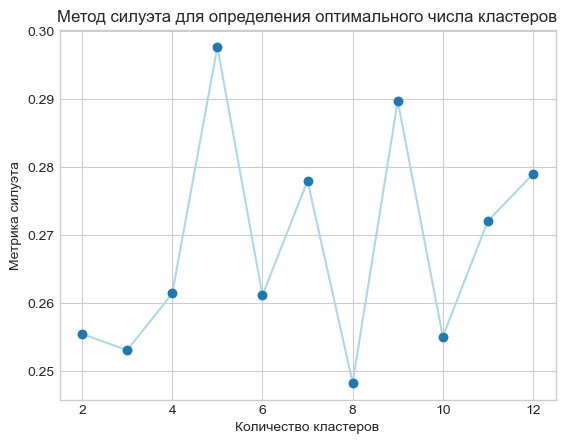

Оптимальное число кластеров (по методу силуэта): 5
Максимальный коэффициент силуэта = 0.30


In [23]:
plt.plot(range(2, max_clusters + 1), siluette_scores, marker="o", color="lightblue", label="Силуэт-оценка")
plt.scatter(range(2, max_clusters + 1), siluette_scores, color="tab:blue", zorder=5)
plt.title("Метод силуэта для определения оптимального числа кластеров")
plt.xlabel('Количество кластеров')
plt.ylabel('Метрика силуэта')
plt.show()

cluster_methods["KMeans"] = kmeans_labels_variants[siluette_scores.index(max(siluette_scores))]
print(f"Оптимальное число кластеров (по методу силуэта): {siluette_scores.index(max(siluette_scores)) + 2}")
print(f"Максимальный коэффициент силуэта = {max(siluette_scores):.2f}")

<h3>Иерархическая (агломеративная) кластеризация</h3>

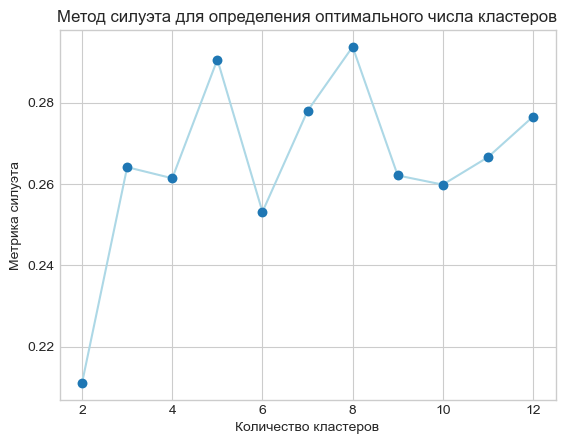

Оптимальное число кластеров (по методу силуэта): 8
Максимальный коэффициент силуэта = 0.29


In [24]:
siluette_scores = []
hierarchical_labels_variants = []

for i in range(2, max_clusters+1):
    hierarchical_model = AgglomerativeClustering(i)
    hierarchical_model.fit(data_encoded)
    # +1 к меткам для удобной работы, визуализации и интерпретации
    siluette_scores.append(silhouette_score(data_encoded, hierarchical_model.labels_ + 1))
    hierarchical_labels_variants.append(hierarchical_model.labels_ + 1)

plt.plot(range(2, max_clusters+1), siluette_scores, marker="o", color="lightblue", label="Силуэт-оценка")
plt.scatter(range(2, max_clusters+1), siluette_scores, color="tab:blue", label="Точки", zorder=5)
plt.title("Метод силуэта для определения оптимального числа кластеров")
plt.xlabel('Количество кластеров')
plt.ylabel('Метрика силуэта')
plt.show()

cluster_methods["Hierarchical"] = hierarchical_labels_variants[siluette_scores.index(max(siluette_scores))]
print(f"Оптимальное число кластеров (по методу силуэта): {siluette_scores.index(max(siluette_scores)) + 2}")
print(f"Максимальный коэффициент силуэта = {max(siluette_scores):.2f}")

Полученные результаты говорят о том, что кластеры скорее всего пересекаются и накладываются: $s\approx 0$

<h4>Построение дендограммы не имеет большого смысла, так как объектов достаточно много</h4>

<h3>DBSCAN</h3>

Подберем оптимальные гиперпараметры eps и min_samples

In [25]:
eps_list = np.arange(0.2, 1, 0.1)
min_samples_list = np.arange(len(data_encoded.columns), 2 * len(data_encoded.columns))
dbscan_labels_variants = []

# Создаем пустой DataFrame для хранения результатов
results_dbscan = pd.DataFrame(columns=["eps", "min_samples", "n_clusters", "n_outliers", "silhouette"])

for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan_model.fit_predict(data_encoded) + 1 # +1 для удобной работы, визуализации и интерпретации

        # Исключаем выбросы (метка 0)
        filtered_labels = labels[labels != 0]
        filtered_data = data_encoded[labels != 0]

        # Рассчитываем количество кластеров и выбросов
        n_clusters = len(np.unique(filtered_labels))
        n_outliers = np.sum(labels == 0)

        if n_clusters > 1 and n_outliers <= 50:  # Минимум два кластера и максимум 50 выбросов
            silhouette = silhouette_score(filtered_data, filtered_labels)
            dbscan_labels_variants.append({"eps": eps, "min_samples": min_samples, "labels": labels})
        else:
            silhouette = None  # Слишком мало кластеров для расчета силуэта

        # Добавляем результаты в DataFrame
        results_dbscan = results_dbscan.append({
            "eps": eps,
            "min_samples": min_samples,
            "n_clusters": n_clusters,
            "n_outliers": n_outliers,
            "silhouette": silhouette
        }, ignore_index=True)

# Преобразования для удобства
results_dbscan["n_clusters"] = results_dbscan["n_clusters"].astype(int)
results_dbscan["n_outliers"] = results_dbscan["n_outliers"].astype(int)
results_dbscan.set_index(["eps", "min_samples"], inplace=True)

# Отфильтруем невалидные результаты
results_dbscan = results_dbscan[results_dbscan["silhouette"].notna()]
print(f"Количество интересующих нас результатов {results_dbscan.shape[0]}")
results_dbscan

Количество интересующих нас результатов 23


n_clusters  n_outliers  silhouette
eps min_samples                                    
0.7 9.0                   8          16    0.329548
    10.0                  9          23    0.323321
    11.0                  7          46    0.331226
    12.0                  7          47    0.331480
    13.0                  8          50    0.319954
0.8 9.0                   8           5    0.327496
    10.0                  8           6    0.327530
    11.0                  8           6    0.327530
    12.0                  8           7    0.327070
    13.0                  8           9    0.327496
    14.0                  8          10    0.327615
    15.0                  8          17    0.325455
    16.0                  8          21    0.325605
    17.0                  7          40    0.326582
0.9 9.0                   4           1    0.273698
    10.0                  4           1    0.273698
    11.0                  4           1    0.273698
    12.0                  4           1    0.273698
    13.0                  4           1    0.273698
    14.0                  4           1    0.273698
    15.0                  4           1    0.273698
    16.0                  4           1    0.273698
    17.0                  4           1    0.273698

Предварительные выводы:
<ul>
    <li>Исходя из анализа таблицы можно сделать вывод, что при радиусе окрестности eps=0.9 метрика силуэта резко падает.</li>
    <li>В остальных случаях метрика силуэта примерно одинакова, будем ориентироваться на количество выбросов (<2%).</li>
</ul>

In [26]:
optimal_filtered = results_dbscan.loc[
    (np.round(results_dbscan.index.get_level_values("eps"), 1) != 0.9) & 
    (results_dbscan["n_outliers"] < 0.02 * data.shape[0])
]
print("Фильтрация по eps <> 0.9 и n_outliers < 20:")
optimal_filtered

Фильтрация по eps <> 0.9 и n_outliers < 20:


n_clusters  n_outliers  silhouette
eps min_samples                                    
0.7 9.0                   8          16    0.329548
0.8 9.0                   8           5    0.327496
    10.0                  8           6    0.327530
    11.0                  8           6    0.327530
    12.0                  8           7    0.327070
    13.0                  8           9    0.327496
    14.0                  8          10    0.327615
    15.0                  8          17    0.325455

Оптимальные параметры для DBSCAN, максимизирующие метрику силуэта и достаточно минимизирующие число объектов-выбросов:
<ul>
    <li>eps = 0.7</li>
    <li>min_samples = 9</li>
</ul>

**Получено 8 кластеров**

In [27]:
best_eps = 0.7
best_min_samples = 9

for variant in dbscan_labels_variants:
    if np.round(variant["eps"], 1) == best_eps and variant["min_samples"] == best_min_samples:
        cluster_methods["DBSCAN"] = variant["labels"]
        break

Все 3 модели имеют **примерно одинаковые** метрики качества. Воспользуемся **методами уменьшения размерности**.

<h2>Поиск кластеров с помошью методов уменьшения размерности</h2>

Отобразим наши кластеры на пространствах с пониженной до 2 компонент размерности

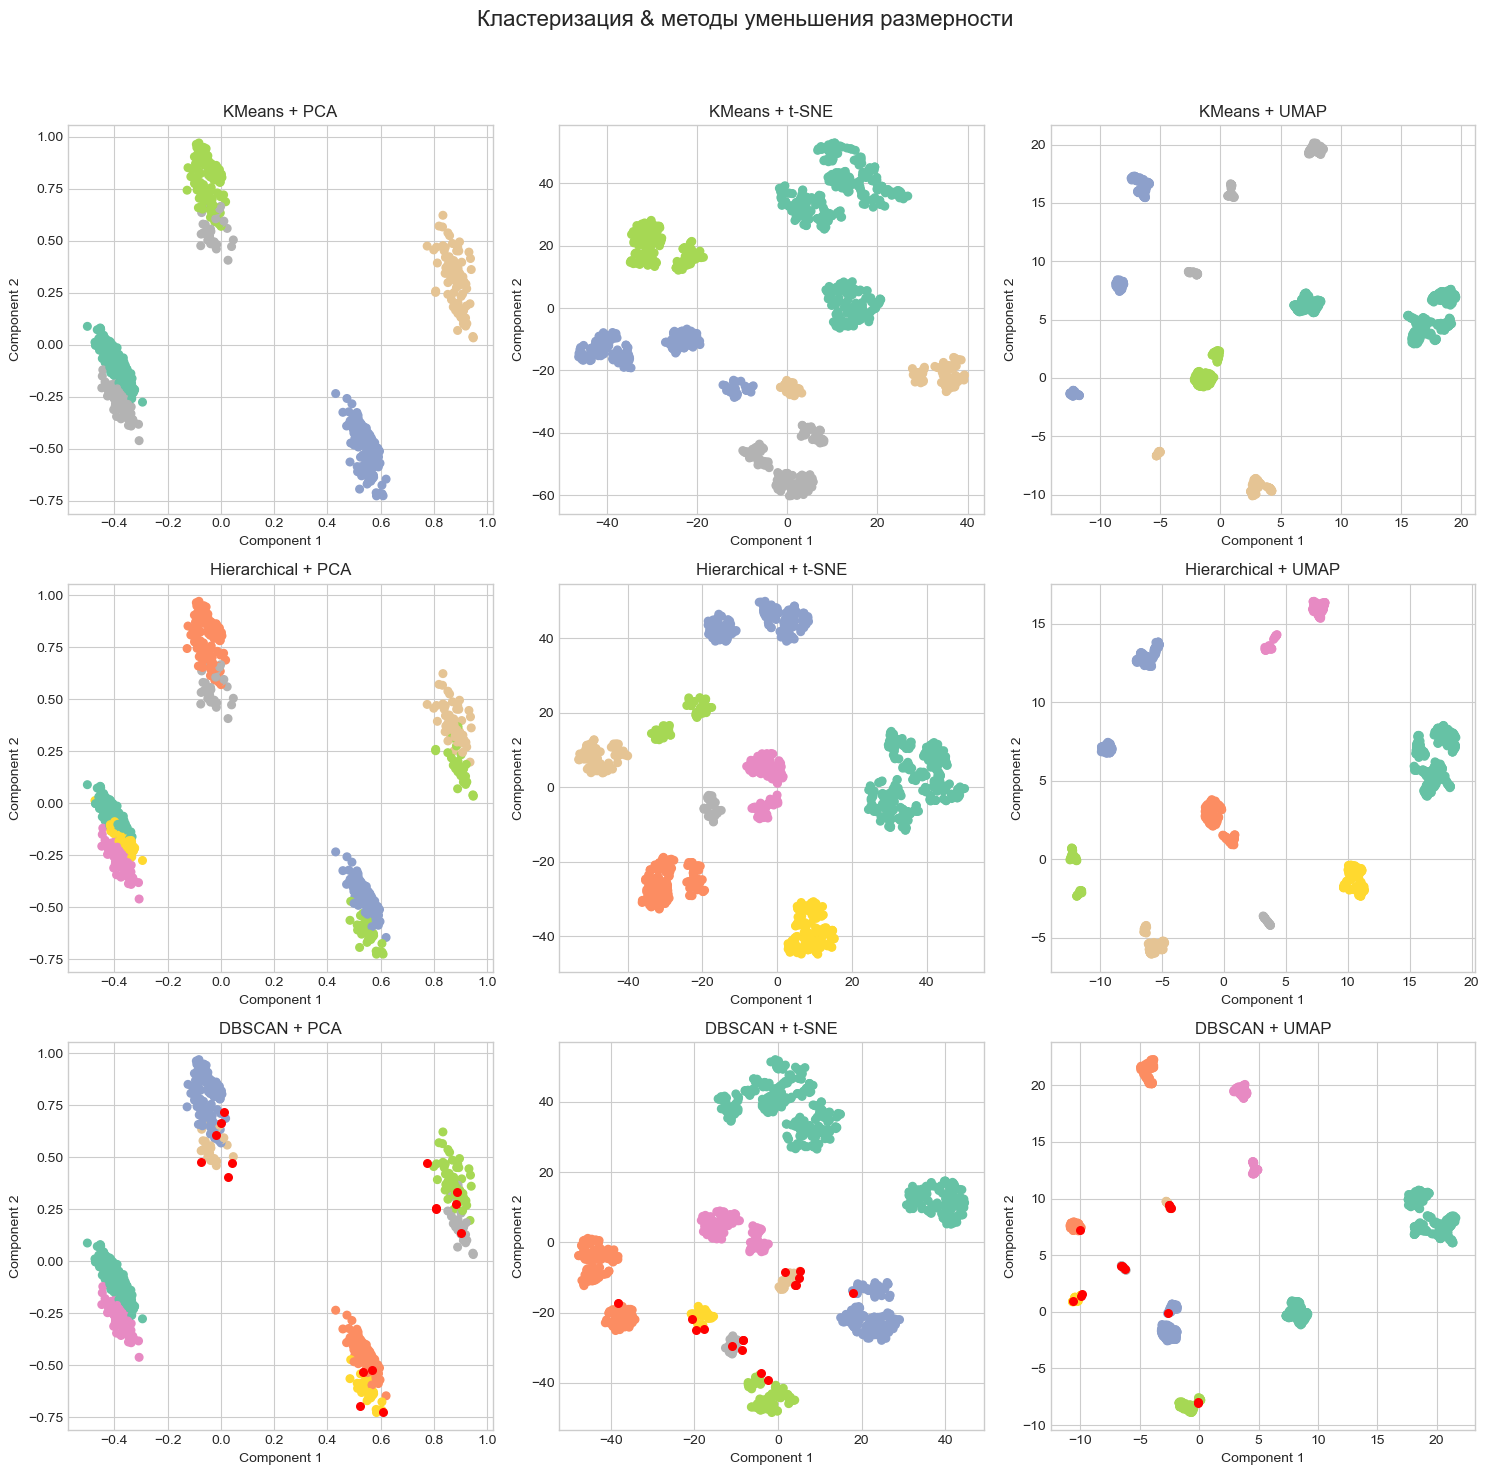

In [28]:
n_components = 2
# Методы уменьшения размерности
dim_reduction_methods = {
    "PCA": PCA(n_components=n_components),
    "t-SNE": TSNE(n_components=n_components),
    "UMAP": umap.UMAP(n_components=n_components),
}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Кластеризация & методы уменьшения размерности", fontsize=16)
for i, (clust_name, labels) in enumerate(cluster_methods.items()):
    for j, (dim_name, reducer) in enumerate(dim_reduction_methods.items()):
        reduced_data = reducer.fit_transform(data_encoded)
        ax = axes[i, j]

        if clust_name == "DBSCAN":
            clusters = labels != 0
            outliers = labels == 0

            scatter = ax.scatter(
                reduced_data[clusters, 0], reduced_data[clusters, 1],
                c=labels[clusters], cmap='Set2', s=30
            )
            ax.scatter(
                reduced_data[outliers, 0], reduced_data[outliers, 1],
                c="red", s=30
            )
        else:
            scatter = ax.scatter(
                reduced_data[:, 0], reduced_data[:, 1],
                c=labels, cmap='Set2', s=30
            )

        ax.set_title(f"{clust_name} + {dim_name}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [29]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_encoded)
print(f"Доля дисперсии, объяснённой 2 компонентами: {100*sum(pca.explained_variance_ratio_):.0f}%")

pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data_encoded)
print(f"Доля дисперсии, объяснённой 2 компонентами: {100*sum(pca.explained_variance_ratio_):.0f}%")

Доля дисперсии, объяснённой 2 компонентами: 41%
Доля дисперсии, объяснённой 2 компонентами: 57%


**Наибольшее** значение **коэффициента силуэта** получено при использовании **DBSCAN** $(s \approx 0.33)$.<br>
Попробуем визуализировать данные в **трёхмерном пространстве**,<br>
потому что **2 компонент** может быть **недостаточно** для объяснения **вариативности** данных

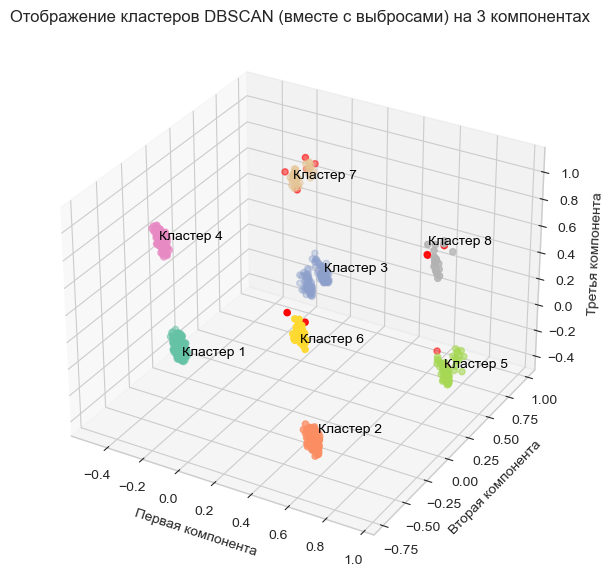

In [30]:
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

clusters = cluster_methods["DBSCAN"] != 0
outliers = cluster_methods["DBSCAN"] == 0

scatter_clusters = ax.scatter(reduced_data[clusters, 0], reduced_data[clusters, 1], reduced_data[clusters, 2], 
                               c=cluster_methods["DBSCAN"][clusters], cmap="Set2")
scatter_outliers = ax.scatter(reduced_data[outliers, 0], reduced_data[outliers, 1], 
                              reduced_data[outliers, 2], c="red")

# Получение уникальных кластеров (исключая выбросы)
unique_clusters = set(cluster_methods["DBSCAN"]) - {0}

# Добавление метки для одной точки каждого кластера
for cluster_label in unique_clusters:
    # Индексы точек текущего кластера
    cluster_indices = (cluster_methods["DBSCAN"] == cluster_label)
    if np.any(cluster_indices):  # Проверяем, есть ли точки в этом кластере
        first_point = reduced_data[cluster_indices][0]
        ax.text(first_point[0], first_point[1], first_point[2],
                f"Кластер {cluster_label}", fontsize=10, color="black")

ax.set_title("Отображение кластеров DBSCAN (вместе с выбросами) на 3 компонентах")
ax.set_xlabel("Первая компонента")
ax.set_ylabel("Вторая компонента")
ax.set_zlabel("Третья компонента")
plt.show()

<h2>Интерпретация результатов</h2>

In [31]:
data_with_clusters = data.copy()
for key, value in cluster_methods.items():
    data_with_clusters[f"{key} cluster"] = value
    
data_with_clusters

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,KMeans cluster,Hierarchical cluster,DBSCAN cluster
0,33,male,2,own,little,little,1169.0,6,radio/TV,1,1,1
1,22,female,2,own,little,moderate,5951.0,18,radio/TV,2,3,2
2,49,male,1,own,little,little,2096.0,12,education,1,1,1
3,45,male,2,free,little,little,7882.0,42,furniture/equipment,3,2,3
4,53,male,2,free,little,little,4870.0,24,car,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,little,1736.0,12,furniture/equipment,2,3,2
996,40,male,3,own,little,little,3857.0,30,car,1,1,1
997,38,male,2,own,little,little,804.0,12,radio/TV,1,1,1
998,23,male,2,free,little,little,1845.0,18,radio/TV,3,2,3


<h4>Кластеры, полученные благодаря DBSCAN</h4>

In [32]:
data_with_clusters["DBSCAN cluster"].value_counts()

1    403
2    156
3    139
4    114
5     84
6     36
7     28
8     24
0     16
Name: DBSCAN cluster, dtype: int64

Отобразим средние статистики (медианы, так как распределения получились асимметричные) в разрезе кластеров

In [33]:
groups_by_dbscan_cluster = data_with_clusters.drop(columns=["Hierarchical cluster", 
                                                            "KMeans cluster"]).groupby("DBSCAN cluster")

groups_by_dbscan_cluster.agg("median").T

DBSCAN cluster,0,1,2,3,4,5,6,7,8
Age,36.5,34.0,29.5,36.0,34.0,25.0,31.0,32.00,25.5
Credit amount,3194.5,2319.5,1910.0,2319.5,2319.5,2139.5,1520.5,2413.25,1894.5
Duration,18.0,18.0,18.0,18.0,18.0,18.0,15.0,18.00,15.0


In [34]:
groups_by_dbscan_cluster.describe(include="object").drop(columns="count", level=1)

Sex                 Job          Housing             \
               unique     top freq unique top freq  unique   top freq   
DBSCAN cluster                                                          
0                   2  female   10      4   1    5       3  rent    7   
1                   1    male  403      4   2  242       1   own  403   
2                   1  female  156      4   2  104       1   own  156   
3                   1    male  139      4   2   87       2  free   75   
4                   1    male  114      4   2   83       1   own  114   
5                   1  female   84      4   2   52       2  rent   70   
6                   1  female   36      3   2   23       1   own   36   
7                   1    male   28      3   2   20       2  rent   18   
8                   1  female   24      3   2   16       2  rent   20   

               Saving accounts                Checking account                 \
                        unique       top freq           unique       top freq   
DBSCAN cluster                                                                  
0                            4  moderate    6                3  moderate   10   
1                            1    little  403                3    little  275   
2                            1    little  156                3    little   99   
3                            1    little  139                3    little   99   
4                            3  moderate   52                3    little   72   
5                            1    little   84                3    little   65   
6                            3  moderate   17                3    little   28   
7                            3  moderate   17                2    little   16   
8                            3  moderate   11                3  moderate   11   

               Purpose                 
                unique       top freq  
DBSCAN cluster                         
0                    7       car    4  
1                    8       car  130  
2                    8  radio/TV   57  
3                    7       car   64  
4                    7  radio/TV   36  
5                    7       car   30  
6                    6       car   16  
7                    5       car   12  
8                    5       car    9

In [35]:
data_with_clusters[["Credit amount", "DBSCAN cluster"]]

,Credit amount,DBSCAN cluster
0,1169.0,1
1,5951.0,2
2,2096.0,1
3,7882.0,3
4,4870.0,3
...,...,...
995,1736.0,2
996,3857.0,1
997,804.0,1
998,1845.0,3


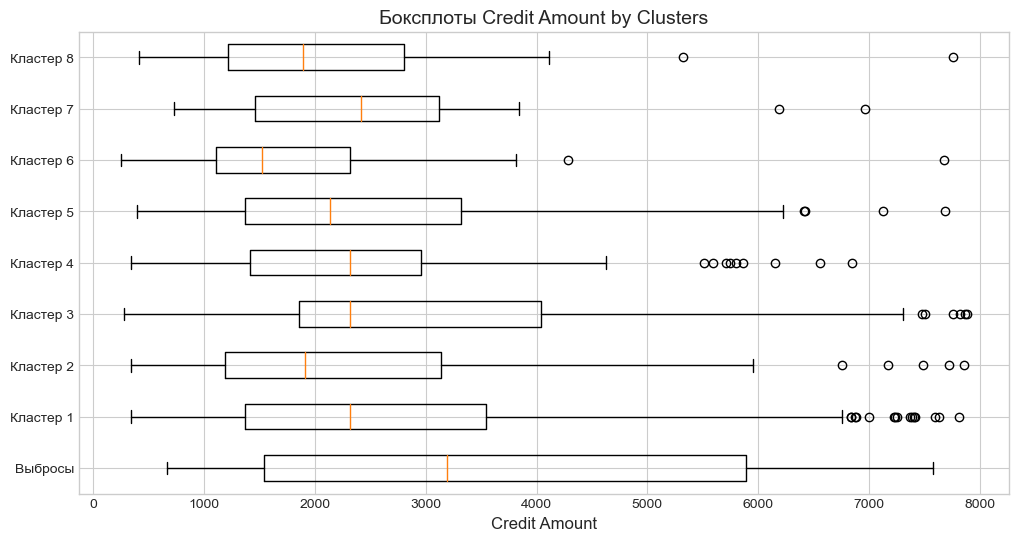

In [36]:
grouped_data = groups_by_dbscan_cluster["Credit amount"]
boxplot_data = [group.values for _, group in grouped_data]

plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, vert=False)
plt.yticks(range(1, len(boxplot_data) + 1), 
           [f"Кластер {i}" if i else "Выбросы" for i in grouped_data.groups.keys()])
plt.xlabel("Credit Amount", fontsize=12)
plt.title("Боксплоты Credit Amount by Clusters", fontsize=14)
plt.show()

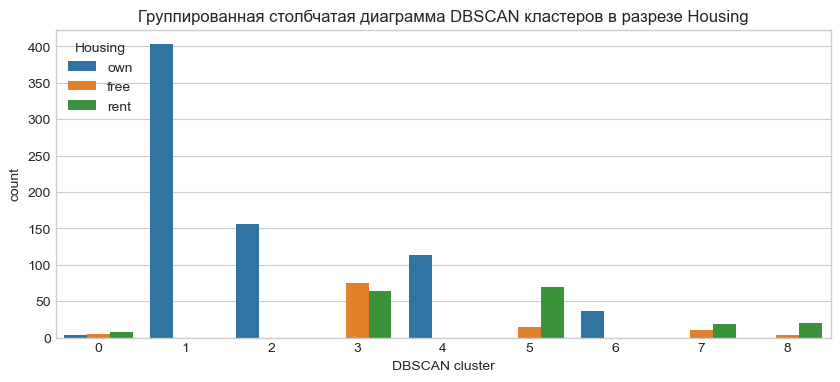

In [37]:
plt.figure(figsize=(10, 4))
sns.countplot(data=data_with_clusters, x="DBSCAN cluster", hue="Housing")
plt.title(f"Группированная столбчатая диаграмма DBSCAN кластеров в разрезе Housing")
plt.show()

Предварительные выводы:
<ol>
    <li>Выбросы отображают группу клиентов с чётко выраженными характеристиками - они (в среднем) обладают намного большей суммой кредитов, старше, среди них чаще всего встречаются неквалифицированные резиденты.</li>
    <li>Во всех кластерах сгруппированы люди одного пола.</li>
    <li>Практически в большинстве кластеров целью кредита является машина.</li>
    <li>По признаку <b>Жилье</b> кластеры можно разбить на 2 группы (в одной группе у всех собственное жилье, во второй - ни у одгого клиента нет собственного жилья.</li>
</ol>

<h4>Кластеры, полученные благодаря KMeans</h4>

In [38]:
data_with_clusters["KMeans cluster"].value_counts()

1    403
2    196
5    147
3    140
4    114
Name: KMeans cluster, dtype: int64

In [39]:
groups_by_kmeans_cluster = data_with_clusters.drop(columns=["Hierarchical cluster", 
                                                            "DBSCAN cluster"]).groupby("KMeans cluster")

groups_by_kmeans_cluster.agg("median").T

KMeans cluster,1,2,3,4,5
Age,34.0,30.0,36.0,26.0,34.0
Credit amount,2319.5,1812.5,2319.5,2203.5,2319.5
Duration,18.0,18.0,18.0,18.0,18.0


In [40]:
groups_by_kmeans_cluster.describe(include="object").drop(columns="count", level=1)

Sex                 Job          Housing             \
               unique     top freq unique top freq  unique   top freq   
KMeans cluster                                                          
1                   1    male  403      4   2  242       1   own  403   
2                   1  female  196      4   2  127       1   own  196   
3                   1    male  140      4   2   87       2  free   76   
4                   1  female  114      4   2   70       2  rent   95   
5                   1    male  147      4   2  104       3   own  114   

               Saving accounts                Checking account               \
                        unique       top freq           unique     top freq   
KMeans cluster                                                                
1                            1    little  403                3  little  275   
2                            4    little  157                3  little  127   
3                            1    little  140                3  little   99   
4                            4    little   86                3  little   77   
5                            3  moderate   71                3  little   90   

               Purpose                 
                unique       top freq  
KMeans cluster                         
1                    8       car  130  
2                    8  radio/TV   68  
3                    7       car   64  
4                    8       car   41  
5                    8       car   49

<h3>Обобщение результатов</h3>

**DBSCAN очень хорошо выявил плотные кластеры.**<br><br>Однако, для **лучшей интерпретации** объединим по 2 похожие кластеры, полученные с использованием DBSCAN.

In [41]:
data_with_clusters["Final cluster"] = 0
data_with_clusters.loc[np.isin(data_with_clusters["DBSCAN cluster"], [1, 4]), "Final cluster"] = 1
data_with_clusters.loc[np.isin(data_with_clusters["DBSCAN cluster"], [2, 6]), "Final cluster"] = 2
data_with_clusters.loc[np.isin(data_with_clusters["DBSCAN cluster"], [3, 7]), "Final cluster"] = 3
data_with_clusters.loc[np.isin(data_with_clusters["DBSCAN cluster"], [5, 8]), "Final cluster"] = 4

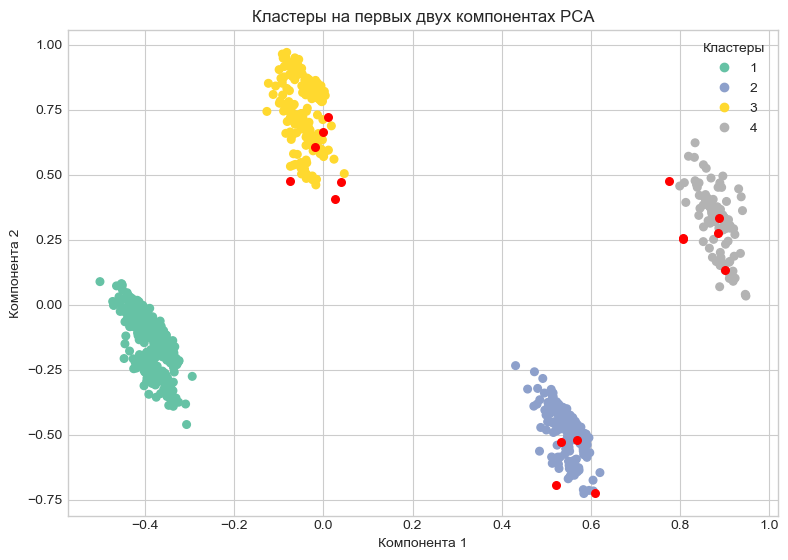

In [42]:
clusters = data_with_clusters["Final cluster"] != 0
outliers = data_with_clusters["Final cluster"] == 0

fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(
    reduced_data[clusters, 0], reduced_data[clusters, 1],
    c=data_with_clusters["Final cluster"][clusters], cmap='Set2', s=30
)

ax.scatter(
    reduced_data[outliers, 0], reduced_data[outliers, 1],
    c="red", s=30
)

ax.set_title("Кластеры на первых двух компонентах PCA")
ax.set_xlabel("Компонента 1")
ax.set_ylabel("Компонента 2")
ax.grid(True)
ax.legend(*scatter.legend_elements(), title="Кластеры")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Соберем основные характеристики кластеров в 2 таблицы (по количественным и качественным признакам)

In [43]:
groups_by_own_cluster = data_with_clusters.drop(columns=["Hierarchical cluster", "KMeans cluster",
                                                            "DBSCAN cluster"]).groupby("Final cluster")

final_pivot_quantitative = groups_by_own_cluster[quantitative].agg(["median", "mean"])

final_pivot_quantitative["Quantity"] = data_with_clusters["Final cluster"].value_counts()
final_pivot_quantitative.index = ["Выбросы", *final_pivot_quantitative.index[1:]]

final_pivot_quantitative

Age            Credit amount              Duration             \
        median       mean        median         mean   median       mean   
Выбросы   36.5  41.000000        3194.5  3816.781250     18.0  20.625000   
1         34.0  35.638298        2319.5  2645.616054     18.0  19.025145   
2         30.0  32.755208        1781.5  2245.062500     16.5  17.281250   
3         35.0  36.574850        2319.5  3083.431138     18.0  19.299401   
4         25.0  30.101852        2139.5  2553.120370     18.0  17.777778   

        Quantity  
                  
Выбросы       16  
1            517  
2            192  
3            167  
4            108

In [44]:
final_pivot_qualitative = groups_by_own_cluster.describe(include="object").drop(columns=["count", "freq"], level=1)

final_pivot_qualitative["Quantity"] = data_with_clusters["Final cluster"].value_counts()
final_pivot_qualitative.index = ["Выбросы", *final_pivot_qualitative.index[1:]]

final_pivot_qualitative

Sex            Job     Housing       Saving accounts            \
        unique     top unique top  unique   top          unique       top   
Выбросы      2  female      4   1       3  rent               4  moderate   
1            1    male      4   2       1   own               4    little   
2            1  female      4   2       1   own               4    little   
3            1    male      4   2       2  free               4    little   
4            1  female      4   2       2  rent               4    little   

        Checking account           Purpose           Quantity  
                  unique       top  unique       top           
Выбросы                3  moderate       7       car       16  
1                      3    little       8       car      517  
2                      3    little       8  radio/TV      192  
3                      3    little       7       car      167  
4                      3    little       7       car      108

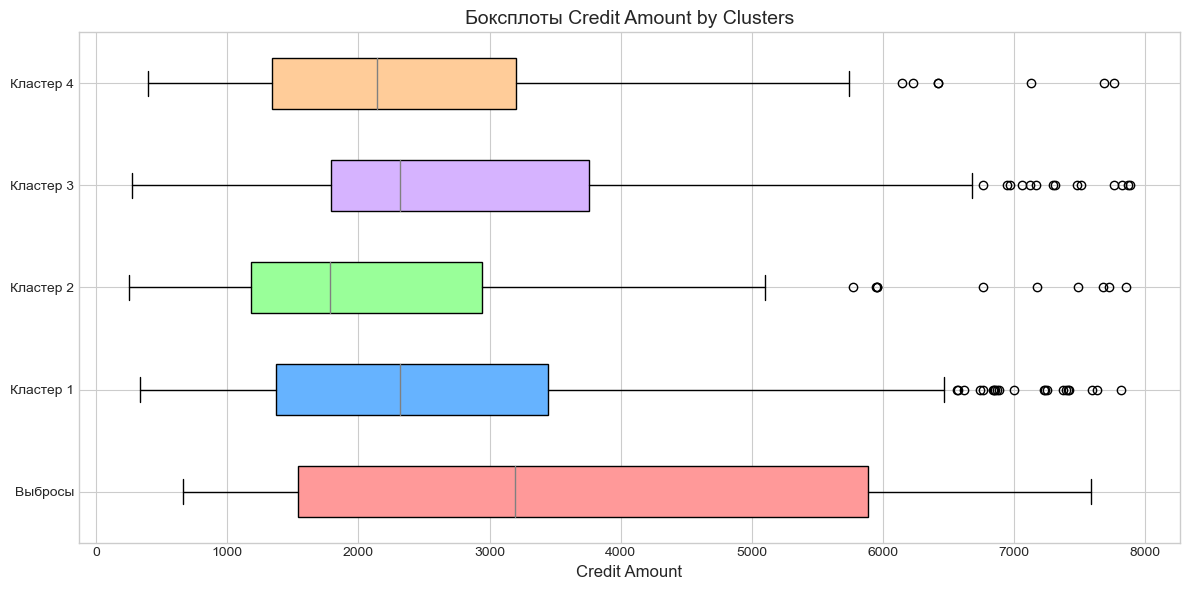

In [45]:
grouped_data = groups_by_own_cluster["Credit amount"]
boxplot_data = [group.values for _, group in grouped_data]

colors = ["#FF9999", "#66B3FF", "#99FF99", "#D6B3FF", "#FFCC99"]

plt.figure(figsize=(12, 6))
box = plt.boxplot(boxplot_data, patch_artist=True, vert=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color("gray")

    
plt.yticks(
    range(1, len(boxplot_data) + 1),
    [f"Кластер {i}" if i else "Выбросы" for i in grouped_data.groups.keys()]
)

plt.xlabel("Credit Amount", fontsize=12)
plt.title("Боксплоты Credit Amount by Clusters", fontsize=14)
plt.tight_layout()

plt.show()

Итого: **4 кластера** и **группа редких клиентов**:
<ol>
    <li>Преобладающая часть клиентов - мужчины зрелого возраста, с собственным жильем, имеющих кредит на автомобиль;</li>
    <li>Женщины, которые владеют жильём, обладают (в среднем) <b>самой меньшей суммой кредита</b> по сравнению с другими,<br>что можно объяснить <b>основной целью кредитов</b> - покупкой радио/телевизоров, а не автомобилей;</li>
    <li>Мужчины (в среднем) с самой большой суммой кредита, с бесплатным жильем;</li>
    <li>Девушки, которые чаще арендуют жилье, у которых (в среднем) сумма кредита меньше медианы/среднего всей выборки;</li>
    <li><b>Неквалифицированные</b> клиенты <b>обоих</b> полов <b>старшего</b> возраста с <b>умеренной</b> суммой на счету и <b>самыми большими кредитами</b> (в среднем).</li>
</ol>